We have a wroking training procedure, now to figure out the prediction.

In [ ]:
import jax.numpy as jnp
import jax

import matplotlib.pyplot as plt
from recurrent_kernel import recurrent_kernel, erf_kernel, weighted_dot, update_fn, diagonal_update_fn
from jax.lax import scan

%config InlineBackend.figure_format = 'svg'

In [2]:
data = jnp.load('u_train.npy')
data_test = jnp.load('u_test.npy')

K_baseline_train = jnp.load('K_baseline_train.npy')
K_baseline_test = jnp.load('K_baseline_test.npy')
vv_baseline = jnp.load("baseline_vv.npy")
K_baseline_full = jnp.concatenate([K_baseline_train, K_baseline_test], axis=0)

In [3]:
scaling = (0.4, 0.9, 0.4)
renorm = 0.11

In [4]:
f = jax.jit(recurrent_kernel, static_argnums=(1, ))
K_train = f(data, erf_kernel, scaling) # compiling

In [5]:
jnp.mean(jnp.abs(K_train - K_baseline_train))

DeviceArray(0.00535375, dtype=float32)

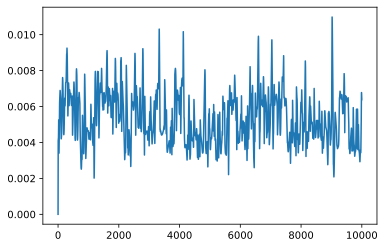

In [6]:
plt.plot(jnp.mean(jnp.abs(K_train - K_baseline_train), axis=0))

(4000.0, 6000.0)

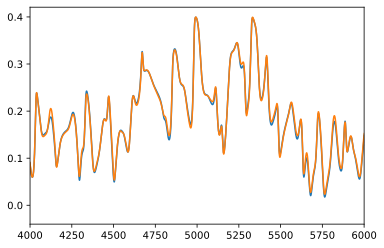

In [7]:
plt.plot(K_baseline_train[:, 5000])
plt.plot(K_train[:, 5000])
plt.xlim([4000, 6000])

In [8]:
jnp.allclose(K_train, K_train.T)

DeviceArray(True, dtype=bool)

Now let's calculate the output layer.

In [9]:
K_train = f(data, erf_kernel, scaling) # compiling
K_train += renorm * jnp.dot(data, data.T)  # Adding gram matrix 

In [10]:
alpha =1e-2 # cant go below 1e-4, thats reasonable
ini = 1 # we remove the first 200 warmup time

K_train = jax.ops.index_add(K_train, jnp.diag_indices(K_train.shape[0]), alpha)
c, low = jax.scipy.linalg.cho_factor(K_train[ini:, ini:], check_finite=False)
W_out = jax.scipy.linalg.cho_solve((c, low), data[ini:], check_finite=False)

In [11]:
jnp.any(jnp.isnan(W_out))

DeviceArray(False, dtype=bool)

We have an output layuer, lets see how well the kernel performs:

In [12]:
K_train = f(data, erf_kernel, scaling)
K_train += renorm * jnp.dot(data, data.T)  # Adding gram matrix 
K_train = K_train[ini:, ini:]

In [13]:
train_prediction = jnp.dot(K_train, W_out)

In [14]:
plot_data = data[ini:, :]

In [15]:
train_prediction.shape

(9999, 100)

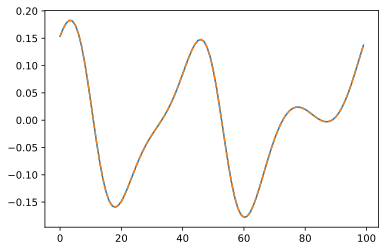

In [16]:
frame = 1000
plt.plot(plot_data[frame])
plt.plot(train_prediction[frame], '--')

Okay that works, now to do prediction. The initial values are the last row of the gram matrix, the last row of K and and the last diagonal value of k.

In [17]:
del K_train
del train_prediction
del c
del low

In [18]:
gram = jnp.dot(data, data.T)
dot_fn = weighted_dot(*scaling)

In [19]:
K_train = f(data, erf_kernel, scaling)

K_predict_ini = K_train[-1, ini:]
gram_predict_ini = gram[-1, ini:]
vv_predict_ini = dot_fn(gram[-1, -1], K_train[-1, -1])

uu = dot_fn(jnp.diag(gram), jnp.diag(K_train))[ini:]

In [48]:
vv_predict_ini

DeviceArray(0.75808525, dtype=float32)

In [49]:
def predict_fn(train_data, W_out, kernel_fn, dot_fn, renorm, uu):
    def predict(carry, _):
        k_prev, gram_prev, vv_prev = carry
        
        # Updating kernel
        k_prev = jnp.pad(k_prev[:-1], (1, 0))
        uv = dot_fn(gram_prev, k_prev)
        k = kernel_fn(uv, vv_prev, uu)
        
        # Calculating corresponding prediction
        u_predict = jnp.dot(k + renorm * gram_prev, W_out)
        
        # Updating corresponding gram matrix
        gram = jnp.dot(train_data, u_predict.T)
        
        # Updating diagonal normalization
        k_vv = kernel_fn(vv_prev, vv_prev, vv_prev)
        vv = dot_fn(jnp.dot(u_predict, u_predict.T), k_vv)
        
        return (k, gram, vv), (u_predict, k, vv, k_vv)
    return predict

In [93]:
rec_pred_fn = predict_fn(data[ini:], W_out, erf_kernel, dot_fn, renorm, uu)

In [94]:
%%time
_, predict = jax.lax.scan(rec_pred_fn, (K_predict_ini, gram_predict_ini, vv_predict_ini), None, length=2000)

CPU times: user 674 ms, sys: 11.6 ms, total: 685 ms
Wall time: 227 ms


In [100]:
parallel_pred = jax.jit(jax.vmap(lambda _ : jax.lax.scan(rec_pred_fn, (K_predict_ini, gram_predict_ini, vv_predict_ini), None, length=2000)))

In [ ]:
%%time
parallel_pred(jnp.ones((10, )));

In [103]:
%%timeit
parallel_pred(jnp.ones((10, )));

88.3 ms ± 43.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [55]:
f = jax.jit(lambda _ :jax.lax.scan(rec_pred_fn, (K_predict_ini, gram_predict_ini, vv_predict_ini), None, length=2000))

In [59]:
%%time
f(2000)

CPU times: user 84.2 ms, sys: 12.1 ms, total: 96.3 ms
Wall time: 95.2 ms


((DeviceArray([0.19726834, 0.24432136, 0.25659215, ..., 0.0900488 ,
               0.08732462, 0.08373192], dtype=float32),
  DeviceArray([2.9289465 , 2.9658806 , 2.9898872 , ..., 0.45474496,
               0.4069022 , 0.34595275], dtype=float32),
  DeviceArray(3.2823973, dtype=float32)),
 (DeviceArray([[0.176548  , 0.20283307, 0.22269064, ..., 0.07641208,
                0.11212575, 0.14597303],
               [0.21022862, 0.24024302, 0.26264596, ..., 0.09397185,
                0.13572204, 0.17498428],
               [0.24936354, 0.28338933, 0.30833903, ..., 0.114353  ,
                0.1632821 , 0.20885181],
               ...,
               [0.38228583, 0.43441457, 0.45914197, ..., 0.11028805,
                0.21447787, 0.3072793 ],
               [0.38228482, 0.43441385, 0.4591416 , ..., 0.11028686,
                0.21447638, 0.30727813],
               [0.38228405, 0.4344131 , 0.45914102, ..., 0.11028564,
                0.21447515, 0.30727696]], dtype=float32),
  DeviceArray

In [65]:
%%timeit 
f(2000)[0][0].block_until_ready()

84.3 ms ± 12.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
K_train = K_train[ini:, ini:]
K_test = predict[1]
vv = predict[2]

In [24]:
K_train.shape

(9999, 9999)

In [25]:
K_full = jnp.concatenate([K_train, K_test], axis=0)

In [26]:
K_full.shape

(11999, 9999)

In [27]:
K_baseline_full.shape

(12000, 10000)

(9800.0, 10500.0)

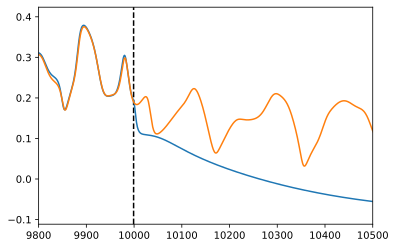

In [31]:
plt.axvline(K_train.shape[0], color='k', linestyle='--')
plt.plot(K_full[:, 5000])
plt.plot(K_baseline_full[:, 5000])


plt.xlim([9800, 10500])

In [32]:
K_full.shape

(11999, 9999)

In [33]:
K_train.shape

(9999, 9999)

In [34]:
K_test.shape

(2000, 9999)

In [35]:
K_baseline_train.shape

(10000, 10000)

(2000.0, 4000.0)

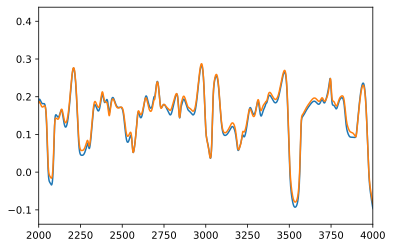

In [36]:
plt.plot(K_baseline_train[-1, ini:])
plt.plot(K_train[-1, :])

plt.xlim([2000, 4000])

(2000.0, 4000.0)

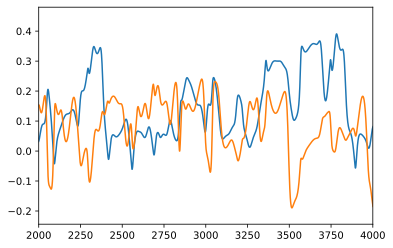

In [38]:
frame = 40
plt.plot(K_baseline_test[frame, ini:], label='')
plt.plot(K_test[frame, :])

plt.xlim([2000, 4000])

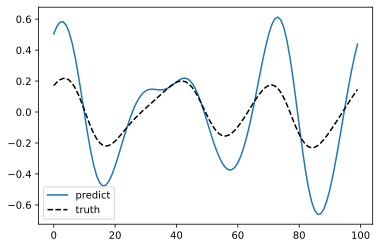

In [39]:
frame = 10

plt.plot(predict[0][frame], label='predict')
plt.plot(data_test[frame], 'k--', label='truth')
plt.legend()

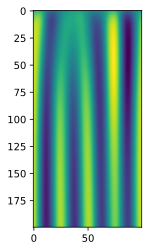

In [40]:
plt.imshow(predict[0][:200])

In [41]:
K_baseline_test.shape

(2000, 10000)

In [42]:
K_test.shape

(2000, 9999)

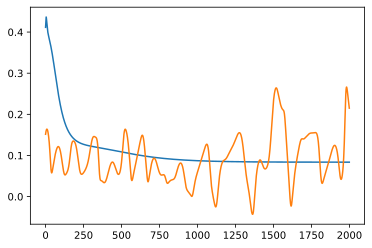

In [43]:
plt.plot(K_test[:, -1])
plt.plot(K_baseline_test[:, 100])

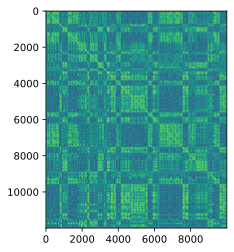

In [44]:
plt.imshow(K_baseline_full)

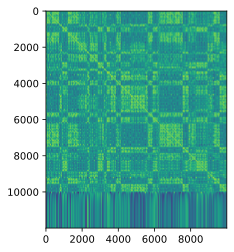

In [45]:
plt.imshow(K_full)

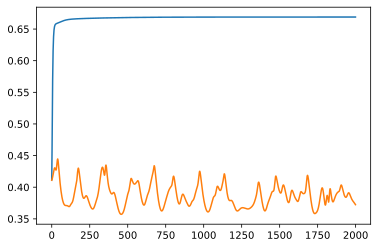

In [47]:
plt.plot(predict[-1])
plt.plot(vv_baseline)

In [73]:
vv_baseline

array([0.41095427, 0.4114387 , 0.41212815, ..., 0.3732226 , 0.37282002,
       0.37240458], dtype=float32)

In [74]:
vv

DeviceArray([0.8307197 , 0.96122634, 1.1362379 , ..., 3.2823975 ,
             3.2823975 , 3.2823975 ], dtype=float32)